# Feature Space Grouping

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from zotbin.group import *
from zotbin.binned import get_zedges_chi

In [3]:
from tomo_challenge import load_data, load_redshift

Found classifier Random
Found classifier ZotBin
Found classifier RandomForest
Found classifier IBandOnly


Load the riz training data:

In [4]:
bands='riz'
include_colors=False
include_errors=False

In [5]:
train_file='/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5'
train_data = load_data(train_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
train_z = load_redshift(train_file)
print(f'Loaded {len(train_data)} training rows.')

Loaded 5410171 training rows.


/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


Use i-r, z-i and i as the input features:

In [6]:
def prepare(band='i', nmax=None, shuffle=False, seed=123):
    n = min(nmax or len(train_data), len(train_data))
    colors = np.diff(train_data, axis=1)
    i = bands.index(band)
    if shuffle:
        gen = np.random.RandomState(seed)
        idx = gen.choice(len(train_data), n, replace=False)
    else:
        idx = slice(None)
    return np.concatenate((colors[idx], train_data[idx, i:i + 1]), axis=1), train_z[idx]

In [7]:
X, z = prepare()

Specify hyperparameters:

In [10]:
npct = 20
nzbin = 120
ngrp = 400

Calculate redshift bins equally spaced in comoving distance:

In [11]:
zedges = get_zedges_chi(z, nzbin=nzbin)

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Plot the feature space rectangular grid:

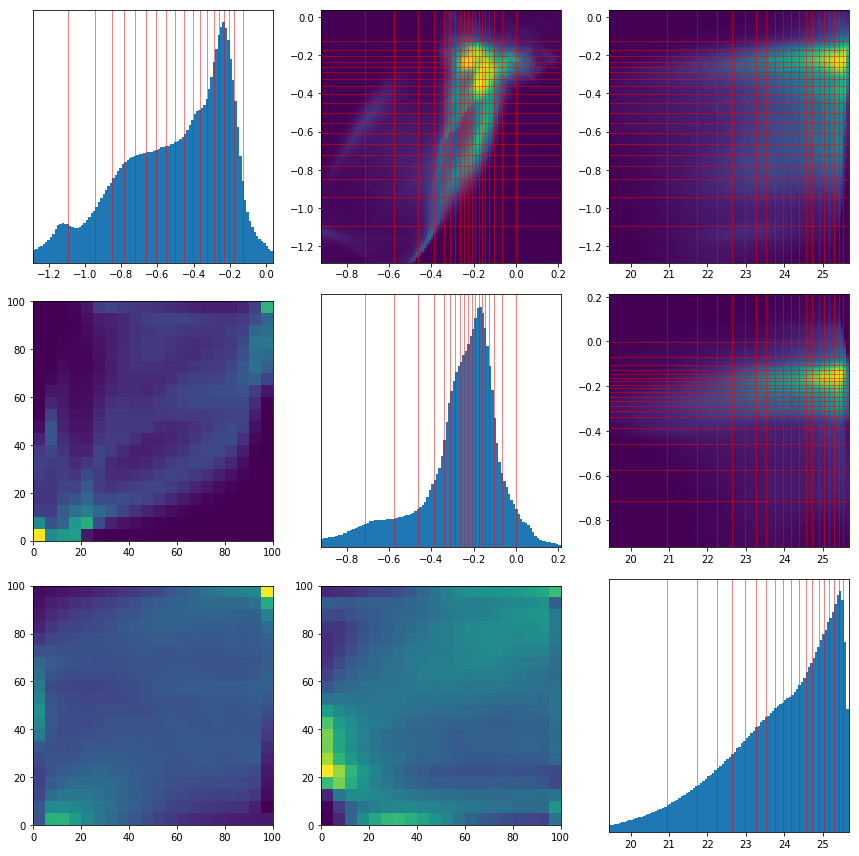

In [10]:
plotfbins(X, npct)

Plot the  corresponding redshift vectors:

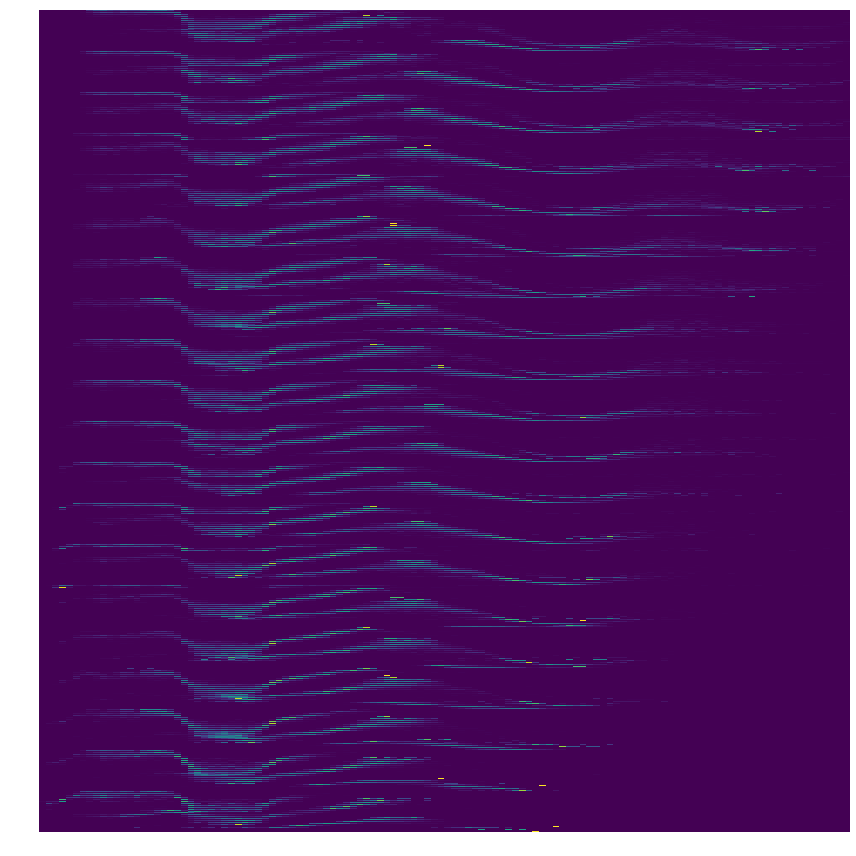

In [11]:
plotzvecs(X, z,  zedges, npct)

Calculate feature-space groups with a weighted redshift similarity measure:

In [10]:
%time fedges, grpid, zhist, zsim = groupbins(X, z, zedges, npct, min_groups=ngrp, weighted=True)

Grouping with ndata=5410171, nmin=27051, nmax=108203, nzbin=120, nfbin=8000.
Reduced to 6936 groups after 100 iterations.
Reduced to 6836 groups after 200 iterations.
Reduced to 6736 groups after 300 iterations.
Reduced to 6636 groups after 400 iterations.
Reduced to 6536 groups after 500 iterations.
Reduced to 6436 groups after 600 iterations.
Reduced to 6433 groups after 700 iterations.
Reduced to 6433 groups after 800 iterations.
Reduced to 6398 groups after 900 iterations.
Reduced to 6300 groups after 1000 iterations.
Reduced to 6200 groups after 1100 iterations.
Reduced to 6100 groups after 1200 iterations.
Reduced to 6000 groups after 1300 iterations.
Reduced to 5900 groups after 1400 iterations.
Reduced to 5807 groups after 1500 iterations.
Reduced to 5707 groups after 1600 iterations.
Reduced to 5626 groups after 1700 iterations.
Reduced to 5626 groups after 1800 iterations.
Reduced to 5626 groups after 1900 iterations.
Reduced to 5614 groups after 2000 iterations.
Reduced to 5

In [12]:
%time fedges, grpid, zhist, zsim = groupbins(X, z, zedges, npct, min_groups=ngrp, weighted=True)

Grouping with ndata=5410171, nmin=27051, nmax=108203, nzbin=120, nfbin=8000.
Reduced to 6936 groups after 100 iterations.
Reduced to 6836 groups after 200 iterations.
Reduced to 6736 groups after 300 iterations.
Reduced to 6636 groups after 400 iterations.
Reduced to 6536 groups after 500 iterations.
Reduced to 6436 groups after 600 iterations.
Reduced to 6433 groups after 700 iterations.
Reduced to 6433 groups after 800 iterations.
Reduced to 6398 groups after 900 iterations.
Reduced to 6300 groups after 1000 iterations.
Reduced to 6200 groups after 1100 iterations.
Reduced to 6100 groups after 1200 iterations.
Reduced to 6000 groups after 1300 iterations.
Reduced to 5900 groups after 1400 iterations.
Reduced to 5807 groups after 1500 iterations.
Reduced to 5707 groups after 1600 iterations.
Reduced to 5626 groups after 1700 iterations.
Reduced to 5626 groups after 1800 iterations.
Reduced to 5626 groups after 1900 iterations.
Reduced to 5614 groups after 2000 iterations.
Reduced to 5

Calculate feature-space groups with an un-weighted redshift similarity measure:

In [13]:
%time fedges2, grpid2, zhist2, zsim2 = groupbins(X, z, zedges, npct, min_groups=ngrp, weighted=False)

Grouping with ndata=5410171, nmin=27051, nmax=108203, nzbin=120, nfbin=8000.
Reduced to 6936 groups after 100 iterations.
Reduced to 6836 groups after 200 iterations.
Reduced to 6736 groups after 300 iterations.
Reduced to 6636 groups after 400 iterations.
Reduced to 6536 groups after 500 iterations.
Reduced to 6436 groups after 600 iterations.
Reduced to 6336 groups after 700 iterations.
Reduced to 6236 groups after 800 iterations.
Reduced to 6136 groups after 900 iterations.
Reduced to 6036 groups after 1000 iterations.
Reduced to 5936 groups after 1100 iterations.
Reduced to 5836 groups after 1200 iterations.
Reduced to 5736 groups after 1300 iterations.
Reduced to 5636 groups after 1400 iterations.
Reduced to 5536 groups after 1500 iterations.
Reduced to 5436 groups after 1600 iterations.
Reduced to 5336 groups after 1700 iterations.
Reduced to 5236 groups after 1800 iterations.
Reduced to 5136 groups after 1900 iterations.
Reduced to 5036 groups after 2000 iterations.
Reduced to 4

Save the results:

In [11]:
save_groups(f'groups_{npct}_{nzbin}_{ngrp}.npz', zedges, fedges, grpid, zhist, zsim)

In [16]:
save_groups(f'groups_{npct}_{nzbin}_{ngrp}.npz', zedges, fedges, grpid, zhist, zsim)
save_groups(f'groups_{npct}_{nzbin}_{ngrp}_nowgt.npz', zedges, fedges2, grpid2, zhist2, zsim2)
!ls -lh groups*.npz

-rw-rw-r-- 1 dkirkby dkirkby 534K Aug 31 16:13 groups_16_120_200_nowgt.npz
-rw-rw-r-- 1 dkirkby dkirkby 534K Aug 31 16:13 groups_16_120_200.npz
-rw-rw-r-- 1 dkirkby dkirkby 566K Aug 31 19:27 groups_20_120_200_nowgt.npz
-rw-rw-r-- 1 dkirkby dkirkby 566K Aug 31 19:27 groups_20_120_200.npz


Plot the redshift distributions in the output groups (sorted by mean z):

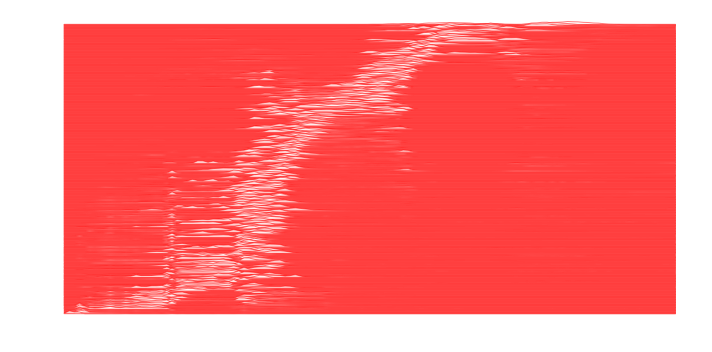

In [12]:
plotzgrp(zhist)

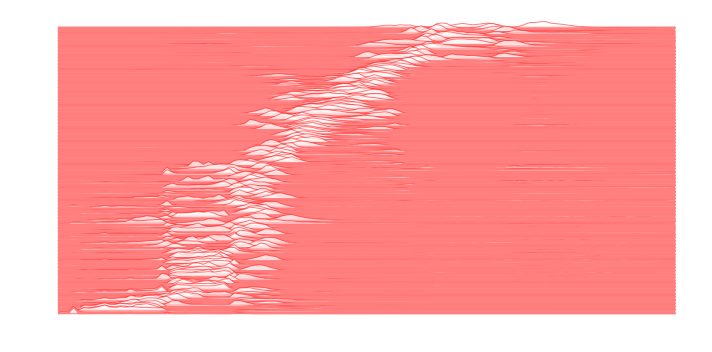

In [17]:
plotzgrp(zhist)

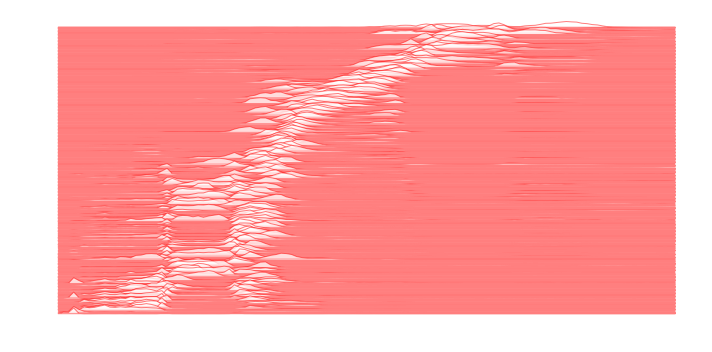

In [23]:
plotzgrp(zhist)

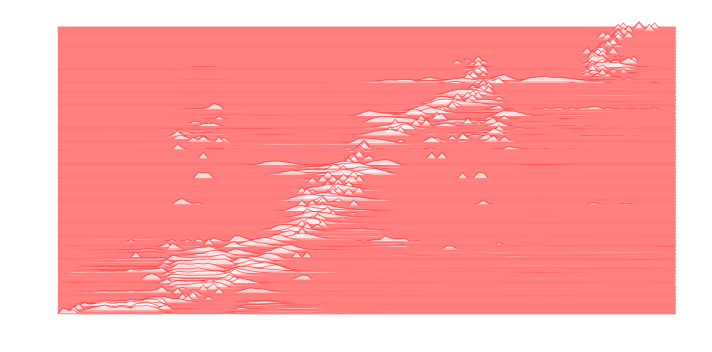

In [18]:
plotzgrp(zhist2)

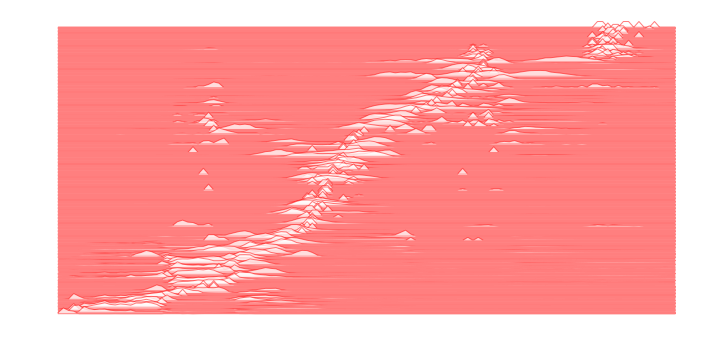

In [24]:
plotzgrp(zhist2)

Do a small test with validation turned on:

In [20]:
groupbins(X[:10000], z[:10000], zedges, npct=10, min_groups=ngrp, weighted=True, validate=True);

Grouping with ndata=10000, nmin=50, nmax=200, nzbin=120, nfbin=1000.
Reduced to 764 groups after 100 iterations.
Reduced to 706 groups after 200 iterations.
Reduced to 676 groups after 300 iterations.
Reduced to 635 groups after 400 iterations.
Reduced to 593 groups after 500 iterations.
Reduced to 546 groups after 600 iterations.
Reduced to 498 groups after 700 iterations.
Reduced to 466 groups after 800 iterations.
Reduced to 435 groups after 900 iterations.
validating similarity matrices after 1000 iterations
Reduced to 389 groups after 1000 iterations.
Reduced to 346 groups after 1100 iterations.
Reduced to 309 groups after 1200 iterations.
Reduced to 273 groups after 1300 iterations.
Reduced to 223 groups after 1400 iterations.
Reached min_groups=200 after 1457 iterations.
Validating final results


Embed groups into a periodic 1D latent space, along the lines of tSNE. This doesn't seem to be useful, perhaps due some bugs.

In [25]:
import jax
import jax.numpy as jnp

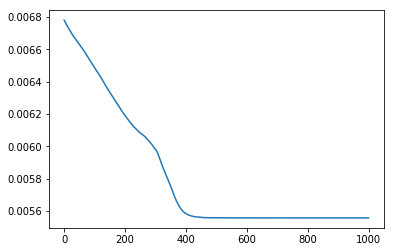

In [26]:
def embed(zsim, nstep=100, eta=0.01, alpha=1, seed=123):
    
    ngrp = len(zsim)
    
    # Initialize random latent space coordinates.
    gen = np.random.RandomState(seed)
    phi = jnp.array(gen.uniform(size=ngrp))
    offdiag = jnp.where(jnp.identity(ngrp) == 0)

    # Normalize the similarity matrix to obtain feature-space probabilities.
    p = jnp.array(zsim / zsim.sum(axis=1, keepdims=True)) ** alpha
    p /= p[offdiag].sum()
    assert jnp.all(p[offdiag] > 0)
    
    # Define a KL loss function.
    @jax.jit
    def KL(phi):
        # Calculate the latent space distance matrix with periodic boundary conditions.
        phi2 = phi.reshape(-1, 1)
        dphisq = (phi2 - phi) ** 2 + 1 - 2 * jnp.maximum(jnp.abs(phi2 - phi), 0.5)
        # Calculate student-t probabilities.
        q = 1 / (1 + dphisq)        
        q /= q[offdiag].sum()
        # Calculate KL(p || q)
        return jnp.sum(p[offdiag] * jnp.log(p[offdiag] / q[offdiag]))
    
    KL_value_grad = jax.jit(jax.value_and_grad(KL))
    
    losses = []
    for i in range(nstep):
        loss, grads = KL_value_grad(phi)
        phi -= eta * grads
        losses.append(float(loss))
        #print(i, losses[-1])
    plt.plot(losses)
    return phi

phi = embed(zsim, eta=10., nstep=1000, seed=1)

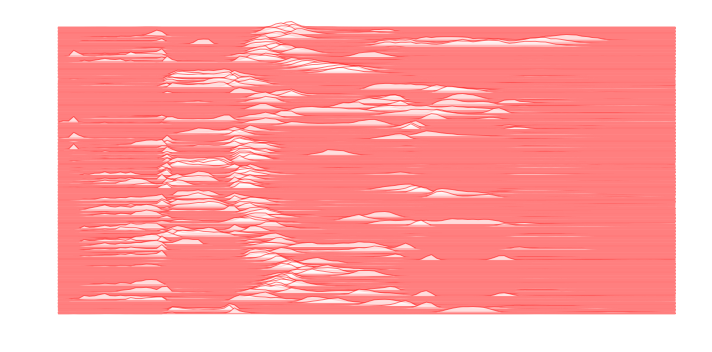

In [29]:
plotzgrp(zhist[np.argsort(phi)], sort=False)

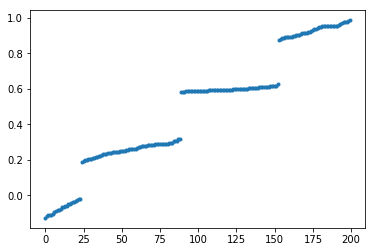

In [31]:
plt.plot(phi[np.argsort(phi)], '.');

## Sandbox

In [12]:
%time fedges, sample_bin, zhist = groupinit(X, z, zedges, npct)

CPU times: user 39.9 s, sys: 133 ms, total: 40 s
Wall time: 40 s


In [13]:
zhist.shape

(8000, 120)

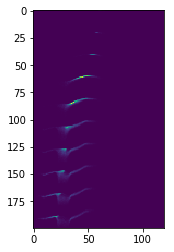

In [16]:
plt.imshow(zhist[:200])